# Example: Solving the diffusion equation 

Here, the function to solve for is $g(x,t)$, where $t$ represents time and $x$ position. The equation to solve for is 

$$
\begin{aligned}
\frac{\partial g(x,t)}{\partial t} &= \nabla^2 g(x,t) \\
&= \frac{\partial^2 g(x,t))}{\partial x^2} \\
\frac{\partial g(x,t)}{\partial t} - \frac{\partial^2 g(x,t))}{\partial x^2}  &= 0
\end{aligned}\label{diffonedim}
$$
with the conditions 
$$
\begin{aligned}
g(0,t) &= 0 ,\qquad &t \geq 0\\
g(1,t) &= 0 ,\qquad &t \geq 0\\
g(x,0) &= u(x), \qquad &x \in [0,1]
\end{aligned} \label{PDEcond}
$$

where $u(x)$ is a given function.
Note that due to the conditions, $u(0) = u(1) = 0$. In this example, we let $u(x) = \sin(\pi x)$.

The left hand side in \eqref{diffonedim} now represents the expression $f$ as discussed in the notes about solving differential equations using deep neural networks. 

First, let us set up the deep neural network. The deep neural network will follow the same structure as discussed in the example solving the ODE describing an exponential decay. 

### Setting up the deep neural network

The only change to do here, is to extend our network such that it handles correctly functions of multiple parameters. In this case we have two, that is time $t$ and position $x$. 
The variables will be represented by a one-dimensional array in the program. So, the program will evaluate the network at each possible pair $(x,t)$, given an array for the desired $x$-values and $t$-values to approximate the solution at. 

### Trial function

$$
g_{\mathrm{trial}}(x,t)) = (1-t)u(x) + x(1-x)tN(x,t,P)
$$

## Using TensorFlow 

As in the example solving for the logistic population growth, TensorFlow can be used to solve this PDE. 
To do so, the neural network is feeded with every point pair $(x_i,t_j)$ for $i = 1,\dots,N_x$ and $j = 1,\dots,N_t$ where $N_x$ and $N_t$ is the number of values for $x$ and $t$, respectively. Thereafter, the computational graph for TensorFlow to evaluate is set up in the construction phase, and then evaluated. 

This program runs much faster than the implementation using Autograd, and seems to be more stable in its calculations. Note that this is only an example of how one might use TensorFlow to solve a PDE, and one might come up with a program utilizing the strength of TensorFlow better. It is possible to run the program using more iterations in the training, and hence let the neural network give results closer to the analytical. 

### Construction phase

In [12]:
import numpy as np 
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Just to reset the graph such that it is possible to rerun this
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()

# Setting a seed such that the results becomes the same after each run of this Jupyter cell
tf.set_random_seed(4155)

# Construct each possible point pair (x,t) to feed the neural network
Nx = 10; Nt = 10
x = np.linspace(0, 1, Nx)
t = np.linspace(0,1,Nt)

X,T = np.meshgrid(x, t)

x_ = (X.ravel()).reshape(-1,1)
t_ = (T.ravel()).reshape(-1,1)

x_tf = tf.convert_to_tensor(x_)
t_tf = tf.convert_to_tensor(t_)

points = tf.concat([x_tf,t_tf],1)

num_iter = 100000

num_hidden_neurons = [30]
num_hidden_layers = np.size(num_hidden_neurons)

with tf.variable_scope('dnn'):
    # Input layer
    previous_layer = points
    
    # Hidden layers
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer
    
    # Output layer
    dnn_output = tf.layers.dense(previous_layer, 1)

    
# Set up the cost function
def u(x):
    return tf.sin(np.pi*x)

with tf.name_scope('cost'):
    g_trial = (1-t_tf)*u(x_tf) + x_tf*(1-x_tf)*t_tf*dnn_output

    g_trial_dt = tf.gradients(g_trial,t_tf)
    g_trial_d2x = tf.gradients(tf.gradients(g_trial,x_tf),x_tf)

    err = tf.square(g_trial_dt[0] - g_trial_d2x[0])
    cost = tf.reduce_sum(err, name = 'cost')

# Define how the neural network should be trained
learning_rate = 0.001
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    traning_op = optimizer.minimize(cost)

# Define a variable to reference to the output from the network
g_dnn_tf = None

# Define a node that initializes all the nodes within the computational graph
# for TensorFlow to evaluate
init = tf.global_variables_initializer()

### Execution phase

The definition of the computational graph is done, making TensorFlow capable of evaluating it.

Initial cost: 1016.31
Final cost: 0.00880429
Max absolute difference between the analytical solution and solution from TensorFlow DNN: 0.0349057


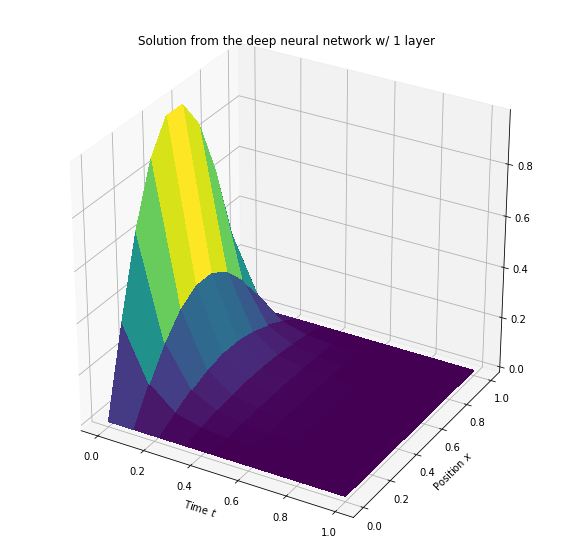

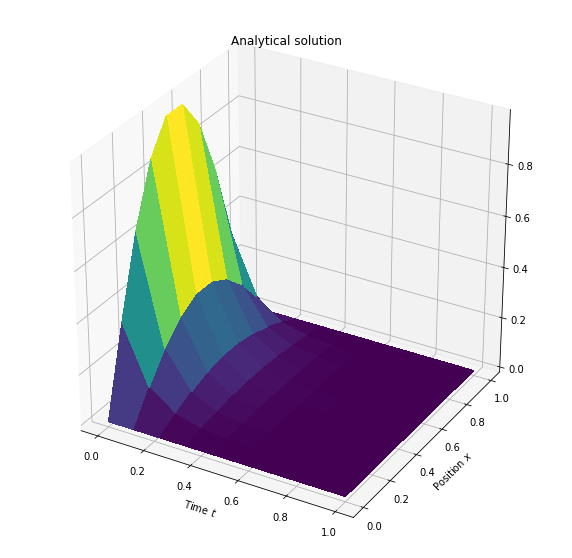

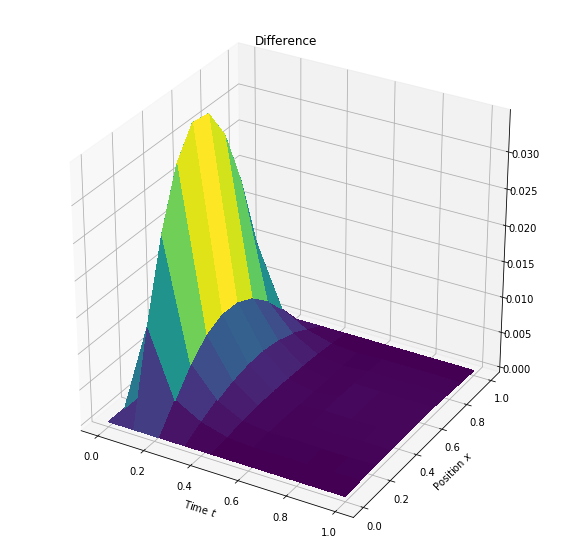

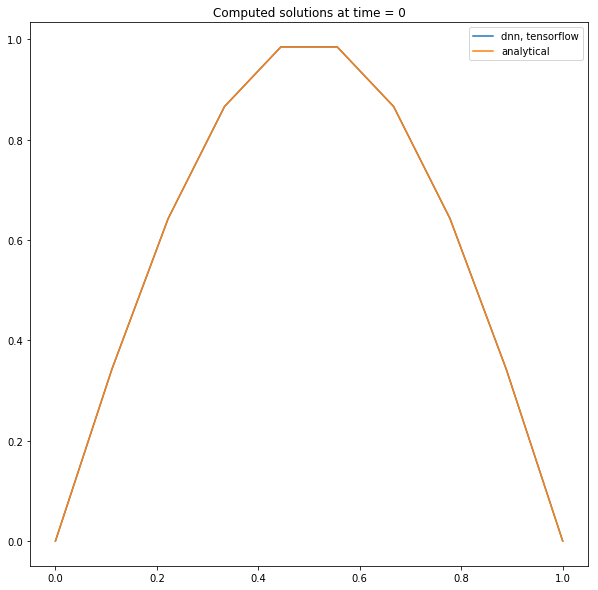

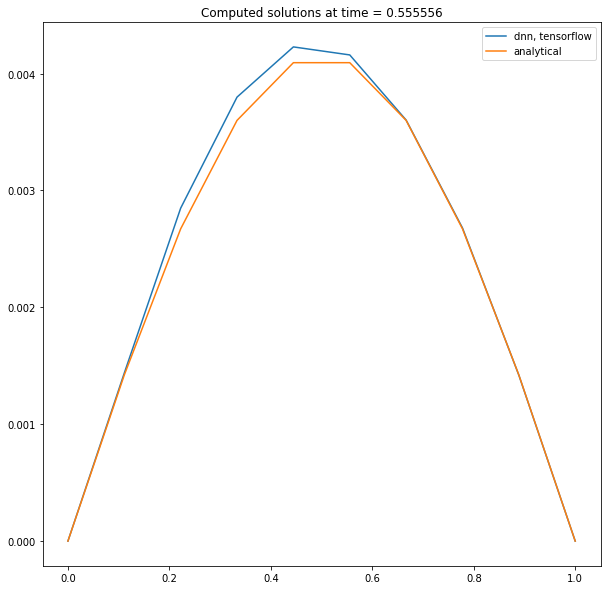

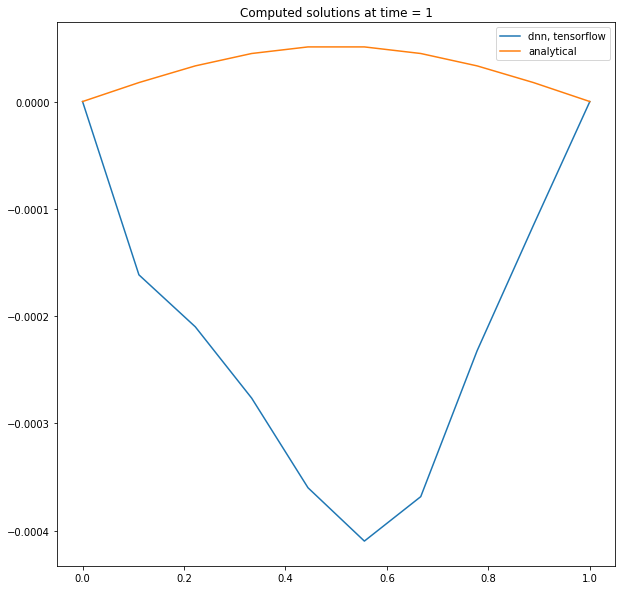

In [13]:
with tf.Session() as sess:
    # Initialize the computational graph
    init.run()
    
    print('Initial cost: %g'%cost.eval())
    
    for i in range(num_iter):
        sess.run(traning_op)

    print('Final cost: %g'%cost.eval())
    
    g_dnn_tf = g_trial.eval()

g_analytic = np.exp(-np.pi**2*t_)*np.sin(np.pi*x_)

diff_tf = np.abs(g_analytic - g_dnn_tf)
print('Max absolute difference between the analytical solution and solution from TensorFlow DNN: %g'%np.max(diff_tf))

## Make a surface plot of the solutions

G_dnn_tf = g_dnn_tf.reshape((Nt,Nx)).T
G_analytical = g_analytic.reshape((Nt,Nx)).T

diff_mat = np.abs(G_analytical - G_dnn_tf)

T,X = np.meshgrid(t, x)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
s = ax.plot_surface(T,X,G_dnn_tf,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$');

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Analytical solution')
s = ax.plot_surface(T,X,G_analytical,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$');

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.set_title('Difference')
s = ax.plot_surface(T,X,diff_mat,linewidth=0,antialiased=False,cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x$');

## Take some 3D slices

indx1 = 0
indx2 = int(Nt/2)
indx3 = Nt-1

t1 = t[indx1]
t2 = t[indx2]
t3 = t[indx3]

# Slice the results from the DNN
res1 = G_dnn_tf[:,indx1]
res2 = G_dnn_tf[:,indx2]
res3 = G_dnn_tf[:,indx3]

# Slice the analytical results
res_analytical1 = G_analytical[:,indx1]
res_analytical2 = G_analytical[:,indx2]
res_analytical3 = G_analytical[:,indx3]

# Plot the slices
plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t1)
plt.plot(x, res1)
plt.plot(x,res_analytical1)
plt.legend(['dnn, tensorflow','analytical'])

plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t2)
plt.plot(x, res2)
plt.plot(x,res_analytical2)
plt.legend(['dnn, tensorflow','analytical'])

plt.figure(figsize=(10,10))
plt.title("Computed solutions at time = %g"%t3)
plt.plot(x, res3)
plt.plot(x,res_analytical3)
plt.legend(['dnn, tensorflow','analytical'])

plt.show()